In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import sys
import getpass
import requests
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import contextily as ctx

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [2]:
pd.DataFrame.

pandas.core.frame.DataFrame

In [2]:
data_dir = '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

# RHNA Site Selection Pre-Screening Dataset Processing

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Step1: Create housing sites dataset on socrata

- This step creates an empty table on the Socrata platform which will serve as our database for following steps

In [3]:
dataset_name= 'Housing Element Site Selection Parcels v2'
dataset_desc= 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool'
columns = [{'fieldName': 'joinid', 'name': 'joinid' , 'dataTypeName': 'text'},
           {'fieldName': 'geom_id', 'name': 'geom_id' , 'dataTypeName': 'text'},
          {'fieldName': 'fipco', 'name': 'county_fips' , 'dataTypeName': 'text'},
          {'fieldName': 'jurisdict', 'name': 'jurisdiction' , 'dataTypeName': 'text'},
          {'fieldName': 'apn_frm', 'name': 'apn_formatted' , 'dataTypeName': 'text'},
          {'fieldName': 'acres', 'name': 'acres' , 'dataTypeName': 'number'},
           {'fieldName': 'exist_lu', 'name': 'existing_land_use' , 'dataTypeName': 'text'},
           {'fieldName': 'public_own', 'name': 'public_ownership' , 'dataTypeName': 'number'},
           {'fieldName': 'vacant', 'name': 'vacant' , 'dataTypeName': 'number'},
           {'fieldName': 'underutilized', 'name': 'underutilized' , 'dataTypeName': 'number'},
           {'fieldName': 'zn_code', 'name': 'zoning_code' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_description', 'name': 'zoning_description' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_area_overlay', 'name': 'zoning__area_overlay' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_max_dua', 'name': 'zoning_max_dua' , 'dataTypeName': 'number'},
           {'fieldName': 'gp_code', 'name': 'general_plan_code' , 'dataTypeName': 'text'},
           {'fieldName': 'gp_description', 'name': 'general_plan_description' , 'dataTypeName': 'text'},
           {'fieldName': 'gp_max_dua', 'name': 'general_plan_max_dua' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_0bdr', 'name': 'fmr_0bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_1bdr', 'name': 'fmr_1bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_2bdr', 'name': 'fmr_2bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_3bdr', 'name': 'fmr_3bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_4bdr', 'name': 'fmr_4bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_4plbdr', 'name': 'fmr_4plbdr' , 'dataTypeName': 'number'},
          {'fieldName': 'tract_geoi', 'name': 'tract_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'blkgp_geoi', 'name': 'block_group_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'reso_level', 'name': 'hcd_community_resource_level' , 'dataTypeName': 'text'},
           {'fieldName': 'fire_risk', 'name': 'calfire_fire_risk' , 'dataTypeName': 'text'},
           {'fieldName': 'fire_autho', 'name': 'calfire_regulatory_authority' , 'dataTypeName': 'text'},
           {'fieldName': 'sea_level', 'name': 'bcdc_sea_level_rise' , 'dataTypeName': 'number'},
           {'fieldName': 'cpad', 'name': 'cal_protected_area_database' , 'dataTypeName': 'number'},
           {'fieldName': 'urban_serv', 'name': 'urban_service_area' , 'dataTypeName': 'number'},
           {'fieldName': 'tra', 'name': 'transit_rich_area' , 'dataTypeName': 'number'},
           {'fieldName': 'pda', 'name': 'priority_development_area' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_5', 'name': 'rhna_5' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_4', 'name': 'rhna_4' , 'dataTypeName': 'number'},
           {'fieldName': 'bldg_permi', 'name': 'bldg_permi' , 'dataTypeName': 'number'},
           {'fieldName': 'vmt', 'name': 'vehicle_miles_traveled' , 'dataTypeName': 'number'},
           {'fieldName': 'x_centroid', 'name': 'x_centroid' , 'dataTypeName': 'number'},
           {'fieldName': 'y_centroid', 'name': 'y_centroid' , 'dataTypeName': 'number'},
          {'fieldName': 'geometry', 'name': 'geometry' , 'dataTypeName': 'multipolygon'}]
category= 'Land & People'
tags = ['housing','housing element','site selection','hcd','housing and community development','rhna']
row_identifier='joinid'
create_socrata_dataset(dataset_name,dataset_desc,columns,category,tags,row_identifier)

created dataset on Socrata with id: 37cj-99yh


{'id': '37cj-99yh',
 'name': 'Housing Element Site Selection Parcels v2',
 'averageRating': 0,
 'category': 'Land & People',
 'createdAt': 1597802263,
 'description': 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool',
 'displayType': 'table',
 'downloadCount': 0,
 'hideFromCatalog': False,
 'hideFromDataJson': False,
 'newBackend': True,
 'numberOfComments': 0,
 'oid': 34991084,
 'provenance': 'official',
 'publicationAppendEnabled': False,
 'publicationGroup': 17460602,
 'publicationStage': 'unpublished',
 'rowIdentifierColumnId': 489166309,
 'rowsUpdatedAt': 1597802263,
 'tableId': 17460602,
 'totalTimesRated': 0,
 'viewCount': 0,
 'viewLastModified': 1597802265,
 'viewType': 'tabular',
 'columns': [{'id': 489166309,
   'name': 'joinid',
   'dataTypeName': 'text',
   'fieldName': 'joinid',
   'position': 1,
   'renderTypeName': 'text',
   'tableColumnId': 112532152,
   'format': {}},
  {'id': 489166310,


In [4]:
#Socrata housing site selection db 4x4
housing_site_db_id = '37cj-99yh'

## Step 2: Pull regional parcel data from Socrata as geojson

- This step pulls in parcel data collected from each County Assessor's office in the 9-County Bay Area in 2018
- These data were processed, cleaned, and standardized by the Data & Visualization team 
- These data will serve the 'framework' data, which overlay data attributes will be added to 

In [5]:
parcel_geojson = pull_geojson_from_socrata('pu8t-xzre')

pulling 2142255 rows as geojson


In [5]:
parcel_geojson['features']

[{'type': 'Feature',
  'geometry': {'type': 'MultiPolygon',
   'coordinates': [[[[-122.120375004, 37.75621461600008],
      [-122.1207991429999, 37.75584255300004],
      [-122.120800068, 37.75584340000006],
      [-122.120801881, 37.75584500700006],
      [-122.120803732, 37.75584658500003],
      [-122.120805617, 37.75584813900008],
      [-122.120807536, 37.75584966700006],
      [-122.120809485, 37.75585116700006],
      [-122.1208114679999, 37.75585264000006],
      [-122.120813486, 37.75585408700005],
      [-122.120815533, 37.75585550400007],
      [-122.1208176119999, 37.75585689300004],
      [-122.12081972, 37.75585825100006],
      [-122.12082186, 37.75585958100004],
      [-122.120824026, 37.75586088300003],
      [-122.120826223, 37.75586215200008],
      [-122.120828447, 37.75586339300003],
      [-122.1208306939999, 37.75586460100004],
      [-122.12083297, 37.75586577900003],
      [-122.1208352739999, 37.75586692500008],
      [-122.120837602, 37.75586803900006],
     

In [6]:
# Convert to geojson to geodataframe
parcel_columns = ['joinid',
                  'geom_id',
                  'fipco',
                  'jurisdict',
                  'apn_frm',
                  'acres',
                  'geometry']
parcels = gp.GeoDataFrame.from_features(parcel_geojson['features'],columns=parcel_columns,crs={'EPSG:4326'})

In [7]:
parcels.crs

{'init': 'epsg:4326'}

In [8]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142255 entries, 0 to 2142254
Data columns (total 7 columns):
 #   Column     Dtype   
---  ------     -----   
 0   joinid     object  
 1   geom_id    object  
 2   fipco      object  
 3   jurisdict  object  
 4   apn_frm    object  
 5   acres      object  
 6   geometry   geometry
dtypes: geometry(1), object(6)
memory usage: 114.4+ MB


### Add representative centroid to gdf

In [10]:
parcels.iloc[1]['geometry'].representative_point().x

-122.12404933242986

In [11]:
parcels['x_centroid'] = parcels['geometry'].representative_point().x
parcels['y_centroid'] = parcels['geometry'].representative_point().y

In [12]:
parcels.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,geometry,x_centroid,y_centroid
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,"MULTIPOLYGON (((-122.12038 37.75621, -122.1208...",-122.120810,37.756050
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,"MULTIPOLYGON (((-122.12385 37.75572, -122.1241...",-122.124049,37.755722
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,"MULTIPOLYGON (((-122.12325 37.75212, -122.1235...",-122.123459,37.752133
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,"MULTIPOLYGON (((-122.12506 37.75429, -122.1252...",-122.125220,37.754517
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,"MULTIPOLYGON (((-122.12854 37.76247, -122.1290...",-122.128952,37.762392


### Upsert to socrata

In [13]:
#Convert geom type from polygon to multipolygon before upsert
parcels['geometry']= [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in parcels["geometry"]]

In [14]:
#Convert geometry to wkt format before upserting to socrata
parcels['geometry'] = parcels['geometry'].map(lambda x: x.wkt)

In [15]:
parcels.head(10)

,joinid,fipco,jurisdict,apn_frm,acres,geometry,x_centroid,y_centroid
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,MULTIPOLYGON (((-122.120375004 37.756214616000...,-122.120810,37.756050
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,MULTIPOLYGON (((-122.1238506989999 37.75571733...,-122.124049,37.755722
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,MULTIPOLYGON (((-122.1232468379999 37.75211693...,-122.123459,37.752133
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,MULTIPOLYGON (((-122.125055068 37.754291018000...,-122.125220,37.754517
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,MULTIPOLYGON (((-122.128541781 37.762467257000...,-122.128952,37.762392
5,AL000006,CA001,Oakland,48-6432-51,0.422807899660084,MULTIPOLYGON (((-122.127357392 37.763071106000...,-122.127592,37.762927
6,AL000007,CA001,Oakland,48-6431-7,0.204664264932627,MULTIPOLYGON (((-122.1316201499999 37.76050719...,-122.131815,37.760448
7,AL000008,CA001,Oakland,48-6313-25,0.274377949904205,MULTIPOLYGON (((-122.124571039 37.754339969000...,-122.124736,37.754585
8,AL000009,CA001,Oakland,48-6313-87,0.137672686739755,MULTIPOLYGON (((-122.126366686 37.753668080000...,-122.126538,37.753635
9,AL000010,CA001,Oakland,48-6298-60,0.163036237080993,MULTIPOLYGON (((-122.121958935 37.756413339000...,-122.122165,37.756370


In [16]:
upsert_df_socrata(parcels,housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 14.1627 minutes


## Step 3: Query Census TIGER Block Groups to get Bay Area Census Tracts & Block Groups
#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

- This is a pre-step for later work. Many of the potential overlay datasets contain Census Tracts level data and in some cases, Census Block Group level data. 
- This step will create a crosswalk between parcels and Census tracts and blocks, using a centroid (parcel representive centroid) in polygon (Census Tract or Block) method.  
- We are using Census Blocks as Blocks nest within tracts. We can therefore get Tracts from Blocks by splitting out the tract geoid from the block geoid.

In [17]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/4/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID,BLKGRP&f=geojson'.format(state=state,counties=counties)
geo_rq = requests.get(url)
blkgp_json = geo_rq.json()

In [30]:
blkgp_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-123.01391599994135, 37.700354999837145],
      [-123.01277699994147, 37.69649799976701],
      [-123.0075480000974, 37.695933999875244],
      [-123.00588400039096, 37.693488999675864],
      [-123.0027939997312, 37.692736000187274],
      [-122.99875400011568, 37.69743800000357],
      [-123.00089300019826, 37.70101100013976],
      [-123.00350699975871, 37.704395999758965],
      [-123.0075480000974, 37.70214000014508],
      [-123.00778599974876, 37.698943000250615],
      [-123.01391599994135, 37.700354999837145]]]},
   'properties': {'GEOID': '060759804011', 'BLKGRP': '1'}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-122.39361799994211, 37.783077999923414],
      [-122.39052700035573, 37.78060700001915],
      [-122.38916800024782, 37.78164899997923],
      [-122

### Create block group geodataframe from geojson data pulled from Census API

In [31]:
blkgp_2018 = gp.GeoDataFrame.from_features(blkgp_json['features'],crs={'EPSG:4326'})

In [32]:
blkgp_2018.crs

{'init': 'epsg:4326'}

In [33]:
blkgp_2018.head(10)

,geometry,GEOID,BLKGRP
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3
5,"POLYGON ((-122.07381 37.69095, -122.07352 37.6...",060014311001,1
6,"POLYGON ((-121.95139 37.34167, -121.95019 37.3...",060855057004,4
7,"POLYGON ((-121.85822 37.39752, -121.85701 37.3...",060855043142,2
8,"POLYGON ((-122.41998 37.76827, -122.41967 37.7...",060750201003,3
9,"POLYGON ((-122.23600 37.48213, -122.23832 37.4...",060816109003,3


### Create a tract column using string slicing

In [34]:
blkgp_2018['tract_geoi'] = blkgp_2018['GEOID'].str.slice(start=0,stop=11)

### Rename geoid column to something that is easier to understand

In [35]:
blkgp_2018.rename(columns={'GEOID':'blkgp_geoi'},inplace=True)

In [36]:
blkgp_2018.head(5)

,geometry,blkgp_geoi,BLKGRP,tract_geoi
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1,06075980401
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6,06075061500
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1,06075026401
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1,06085513500
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3,06001423700


### Create centroid geodataframe using the representative x,y centroids created in previous steps

In [37]:
parcels_centroid = gp.GeoDataFrame(parcels,
                                  geometry=gp.points_from_xy(parcels.x_centroid,parcels.y_centroid),
                                   crs={'EPSG:4326'})

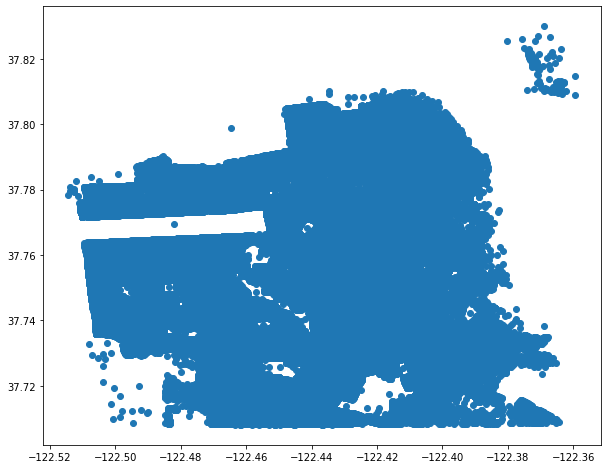

In [38]:
parcels_centroid[parcels_centroid['jurisdict'] == 'San Francisco'].plot(figsize=(10,10));

### Perform point on polygon overlay

In [39]:
parcels_centroid.crs

{'init': 'epsg:4326'}

In [40]:
blkgp_2018.crs

{'init': 'epsg:4326'}

In [41]:
parcels_centroid_census = gp.sjoin(parcels_centroid,
                                   blkgp_2018,
                                   how='left',
                                  op='intersects')

In [42]:
parcels_centroid_census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 12 columns):
 #   Column       Dtype   
---  ------       -----   
 0   joinid       object  
 1   fipco        object  
 2   jurisdict    object  
 3   apn_frm      object  
 4   acres        object  
 5   geometry     geometry
 6   x_centroid   float64 
 7   y_centroid   float64 
 8   index_right  float64 
 9   blkgp_geoi   object  
 10  BLKGRP       object  
 11  tract_geoi   object  
dtypes: float64(3), geometry(1), object(8)
memory usage: 212.5+ MB


In [43]:
parcels_centroid_census.head(10)

,joinid,fipco,jurisdict,apn_frm,acres,geometry,x_centroid,y_centroid,index_right,blkgp_geoi,BLKGRP,tract_geoi
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,POINT (-122.12081 37.75605),-122.120810,37.756050,1705.0,060014099004,4,06001409900
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,POINT (-122.12405 37.75572),-122.124049,37.755722,1705.0,060014099004,4,06001409900
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,POINT (-122.12346 37.75213),-122.123459,37.752133,1705.0,060014099004,4,06001409900
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,POINT (-122.12522 37.75452),-122.125220,37.754517,1705.0,060014099004,4,06001409900
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,POINT (-122.12895 37.76239),-122.128952,37.762392,1775.0,060014099003,3,06001409900
5,AL000006,CA001,Oakland,48-6432-51,0.422807899660084,POINT (-122.12759 37.76293),-122.127592,37.762927,1775.0,060014099003,3,06001409900
6,AL000007,CA001,Oakland,48-6431-7,0.204664264932627,POINT (-122.13182 37.76045),-122.131815,37.760448,1775.0,060014099003,3,06001409900
7,AL000008,CA001,Oakland,48-6313-25,0.274377949904205,POINT (-122.12474 37.75459),-122.124736,37.754585,1705.0,060014099004,4,06001409900
8,AL000009,CA001,Oakland,48-6313-87,0.137672686739755,POINT (-122.12654 37.75363),-122.126538,37.753635,2540.0,060014100002,2,06001410000
9,AL000010,CA001,Oakland,48-6298-60,0.163036237080993,POINT (-122.12216 37.75637),-122.122165,37.756370,1705.0,060014099004,4,06001409900


### Inspect tracts will null geoids to see why they were not assigned a value
- Appears that these tracts are mostly water tracts

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


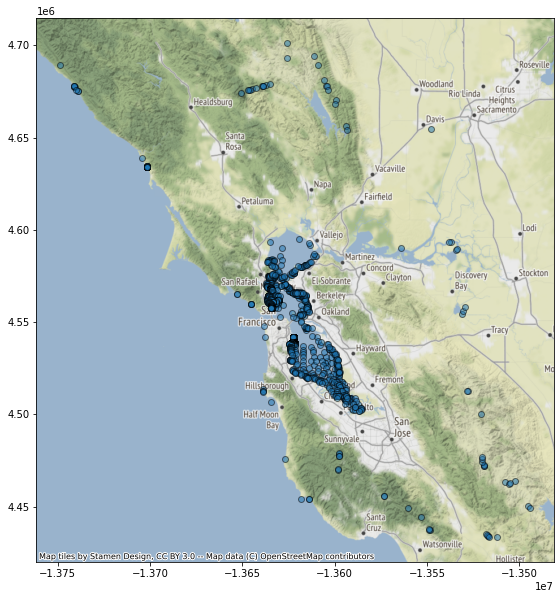

In [44]:
parcels_null_tract = parcels_centroid_census[parcels_centroid_census['tract_geoi'].isnull()].to_crs({'init': 'epsg:3857'})
ax = parcels_null_tract.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

### Subset pracels_centroid_census geodataframe for upsert to Socrata

In [45]:
parcels_centroid_census.columns

Index(['joinid', 'fipco', 'jurisdict', 'apn_frm', 'acres', 'geometry',
       'x_centroid', 'y_centroid', 'index_right', 'blkgp_geoi', 'BLKGRP',
       'tract_geoi'],
      dtype='object')

In [46]:
sub_columns = ['joinid','blkgp_geoi','tract_geoi']
upsert_df_socrata(parcels_centroid_census[sub_columns],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 9.1556 minutes


### Add geom_id column to site selection dataset for later joins to land use and buildings data
- This step should have been performed during step one but was added after team deliberation

In [10]:
upsert_df_socrata(parcels[['joinid','geom_id']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 10.0626 minutes
